<a href="https://colab.research.google.com/github/Dirac-2005/Event_clasiffication/blob/main/event_clasiffication_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Initial shape: (70606, 61)
Event type counts:
 mc_label
bbbar    35765
ccbar    23333
uubar     8172
ddbar     1879
ssbar     1457
Name: count, dtype: int64
Final feature count after cleaning: 50
Train/Test shapes: (52954, 50) (17652, 50)
Estimating feature importances with RandomForest...
Top 12 features:
 ['R2', 'thrustOm', 'KSFWVariables__bohoo2__bc', 'thrust', 'cosTBTO', 'CleoConeCS__bo1__bc', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'KSFWVariables__bohso02__cmFS1__bc', 'thrustBm', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc']


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification report:
               precision    recall  f1-score   support

       bbbar       0.79      0.90      0.84      8942
       ccbar       0.61      0.71      0.65      5833
       ddbar       0.00      0.00      0.00       470
       ssbar       0.00      0.00      0.00       364
       uubar       0.41      0.12      0.19      2043

    accuracy                           0.70     17652
   macro avg       0.36      0.35      0.34     17652
weighted avg       0.65      0.70      0.66     17652

Confusion matrix:
 [[8008  899    0    0   35]
 [1457 4157    0    0  219]
 [ 124  294    0    0   52]
 [  90  230    0    0   44]
 [ 517 1281    0    0  245]]
PCA components for 95% variance: 7


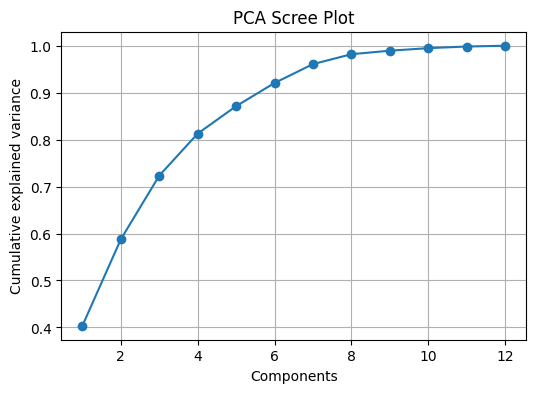

In [ ]:
# Install dependencies if missing
# !pip install pandas numpy scikit-learn matplotlib joblib

import os, joblib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# CONFIG
# --------------------------
CSV_PATH = "data_hep - data_hep.csv"   # use the exact name in your Colab sidebar
TOP_N_FEATURES = 12
RANDOM_STATE = 42

# --------------------------
# 1. Load data
# --------------------------
print("Loading dataset...")
df = pd.read_csv(CSV_PATH)
print("Initial shape:", df.shape)

# Drop bookkeeping column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type to labels
def map_type(t):
    if t in (0,1): return "bbbar"
    return {2:"ccbar", 3:"uubar", 4:"ddbar", 5:"ssbar"}.get(t, "other")

df["mc_label"] = df["type"].map(map_type)
print("Event type counts:\n", df["mc_label"].value_counts())

# --------------------------
# 2. Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constant features
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop very low variance features
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final feature count after cleaning:", len(features))

# --------------------------
# 3. Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["mc_label"].values
le = LabelEncoder()
y_enc = le.fit_transform(y)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=RANDOM_STATE
)
print("Train/Test shapes:", Xtr.shape, Xte.shape)

# --------------------------
# 4. Feature importance (RandomForest)
# --------------------------
print("Estimating feature importances with RandomForest...")
rf = RandomForestClassifier(
    n_estimators=150, max_depth=7, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(TOP_N_FEATURES).index.tolist()
print(f"Top {TOP_N_FEATURES} features:\n", topN)

# --------------------------
# 5. Train reduced model (Logistic Regression)
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(
    max_iter=500, multi_class="multinomial", solver="saga", random_state=RANDOM_STATE, n_jobs=-1
)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# 6. PCA on reduced features
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)
n95 = int(np.searchsorted(cumvar, 0.95) + 1)
print("PCA components for 95% variance:", n95)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()


Binary_classification

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64
Final features: 50
Top 12 features: ['R2', 'thrustOm', 'thrust', 'KSFWVariables__bohoo2__bc', 'cosTBTO', 'foxWolframR2', 'KSFWVariables__bohso02__bc', 'thrustBm', 'KSFWVariables__bohso02__cmFS1__bc', 'CleoConeCS__bo1__bc', 'KSFWVariables__bohso12__bc', 'KSFWVariables__bohso12__cmFS1__bc']

Classification Report:
               precision    recall  f1-score   support

          BB       0.82      0.85      0.83      8942
   continuum       0.84      0.80      0.82      8710

    accuracy                           0.83     17652
   macro avg       0.83      0.83      0.83     17652
weighted avg       0.83      0.83      0.83     17652

Confusion Matrix:
 [[7621 1321]
 [1707 7003]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


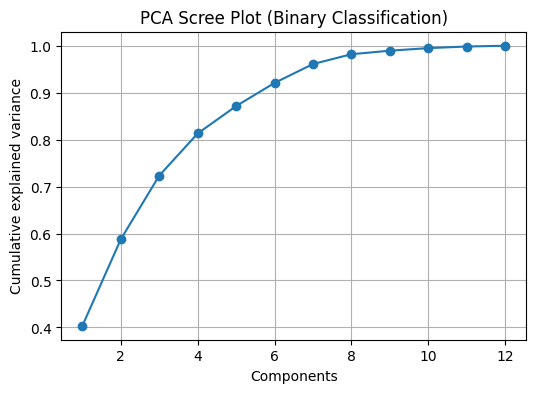

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1): return "BB"          # Signal
    else: return "continuum"            # Background

df["binary_label"] = df["type"].map(map_binary)

print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Clean features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [c for c in features if c not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# Correlation pruning
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
df = df.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print("Final features:", len(features))

# --------------------------
# Prepare data
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)   # 0 = BB, 1 = continuum (or vice versa)

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Feature importance
# --------------------------
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)

feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
topN = feat_imp.head(12).index.tolist()
print("Top 12 features:", topN)

# --------------------------
# Train reduced Logistic Regression
# --------------------------
Xtr_red = Xtr[:, [features.index(f) for f in topN]]
Xte_red = Xte[:, [features.index(f) for f in topN]]

scaler = StandardScaler().fit(Xtr_red)
Xtr_red_s = scaler.transform(Xtr_red)
Xte_red_s = scaler.transform(Xte_red)

lr = LogisticRegression(max_iter=500, solver="saga", random_state=42)
lr.fit(Xtr_red_s, ytr)

ypred = lr.predict(Xte_red_s)

print("\nClassification Report:\n", classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

# --------------------------
# PCA Scree Plot
# --------------------------
pca = PCA().fit(Xtr_red_s)
cumvar = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker="o")
plt.xlabel("Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot (Binary Classification)")
plt.grid(True)
plt.show()


Same with others

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== Random Forest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]

Top 15 features from RF:
 R2                                   0.180411
thrustOm                             0.080225
KSFWVariables__bohoo2__bc            0.051144
KSFWVariables__bohoo2__cmFS1__bc     0.046634
thrust                               0.043895
cosTBTO                              0.041816
thrustBm                             0.041082
foxWolframR2                         0.035877
KSFWVariables__bohso02__bc           0.030666
CleoConeCS__bo1__bc                  0.026905
KSFWVariables__bohso02__cmFS1__bc    0.021973
KSFWVariables__bohso12__bc           0.021213
KSFWVariables__bohso12__cmFS1__

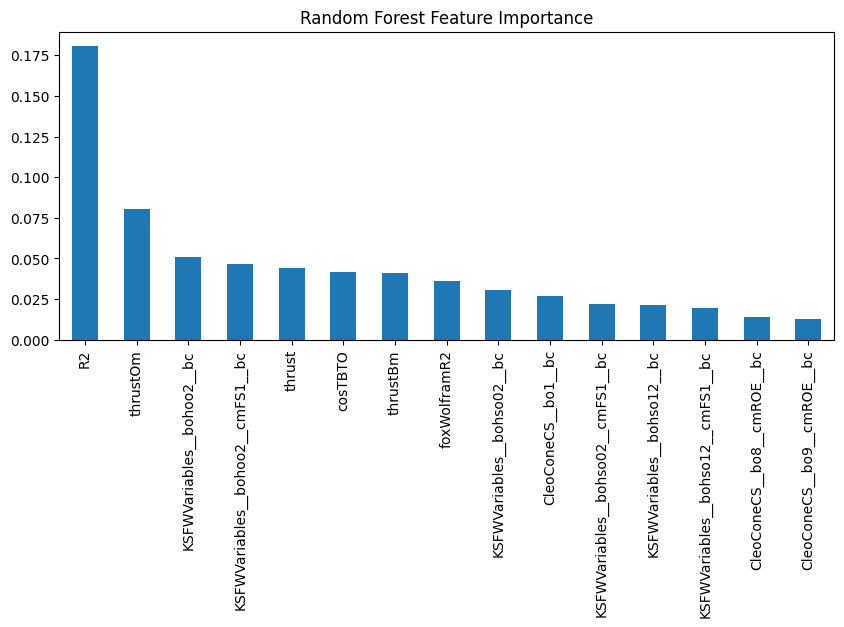

Top 15 XGBoost features:
 R2                                  0.417374
CleoConeCS__bo1__bc                 0.024587
thrustOm                            0.021853
CleoConeCS__bo1__cmROE__bc          0.021792
thrustBm                            0.021266
KSFWVariables__bohoo0__cmFS1__bc    0.020400
KSFWVariables__bohso20__bc          0.016594
KSFWVariables__bohoo0__bc           0.015780
KSFWVariables__bohso12__bc          0.014284
KSFWVariables__bomm2__bc            0.014094
CleoConeCS__bo2__bc                 0.013597
KSFWVariables__boet__bc             0.013417
KSFWVariables__bohso22__bc          0.013010
cosTBz                              0.012312
thrust                              0.011697
dtype: float32


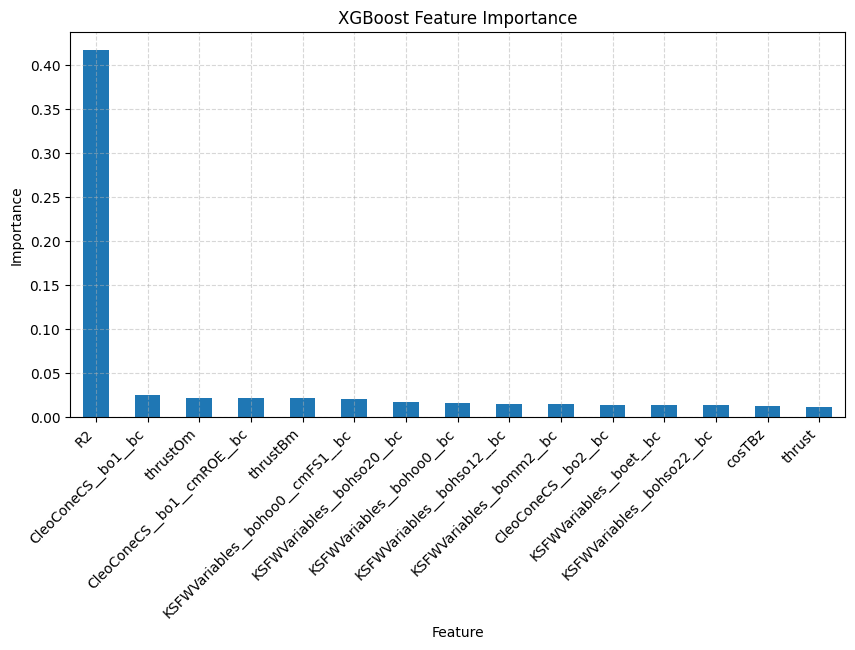

<Figure size 1000x600 with 0 Axes>

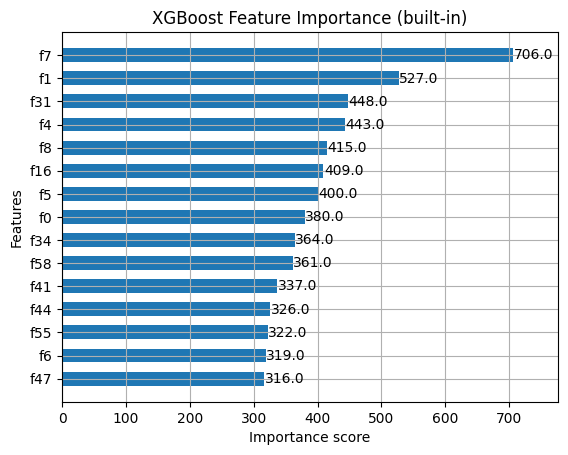

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

# Drop bookkeeping col
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Map event type -> binary class
def map_binary(t):
    if t in (0,1):
        return "BB"          # Signal
    else:
        return "continuum"   # Background

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# --------------------------
# Prepare features
# --------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

# Drop low variance
variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# --------------------------
# Scale features
# --------------------------
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# 1. Random Forest
# --------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,        # Let trees grow fully
    min_samples_leaf=5,    # Prevent overfitting
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr_s, ytr)
ypred_rf = rf.predict(Xte_s)

print("\n=== Random Forest ===")
print(classification_report(yte, ypred_rf, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_rf))

# --------------------------
# 2. Gradient Boosting (XGBoost)
# --------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(Xtr_s, ytr)
ypred_xgb = xgb_model.predict(Xte_s)

print("\n=== XGBoost ===")
print(classification_report(yte, ypred_xgb, target_names=le.classes_, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(yte, ypred_xgb))

# --------------------------
# Optional: Feature importance from Random Forest
# --------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
top_features = importances.head(15)
print("\nTop 15 features from RF:\n", top_features)
top_features.plot(kind='bar', figsize=(10,4), title='Random Forest Feature Importance')
plt.show()
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# XGBoost feature importance
# --------------------------
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

# Top 15 features
top_xgb = xgb_importances.head(15)
print("Top 15 XGBoost features:\n", top_xgb)

# Plot
plt.figure(figsize=(10,5))
top_xgb.plot(kind='bar', title='XGBoost Feature Importance')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: XGBoost built-in plot
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, height=0.6)
plt.title("XGBoost Feature Importance (built-in)")
plt.show()



diffrents_models

Event counts:
 binary_label
BB           35765
continuum    34841
Name: count, dtype: int64

=== RandomForest ===
              precision    recall  f1-score   support

          BB       0.85      0.88      0.86      8942
   continuum       0.87      0.84      0.85      8710

    accuracy                           0.86     17652
   macro avg       0.86      0.86      0.86     17652
weighted avg       0.86      0.86      0.86     17652

Confusion Matrix:
 [[7840 1102]
 [1385 7325]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

          BB       0.88      0.90      0.89      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8021  921]
 [1140 7570]]
[LightGBM] [Info] Number of positive: 26131, number of negative: 26823
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15045
[LightGBM] [Info] Number of data points in the train set: 52954, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493466 -> initscore=-0.026137
[LightGBM] [Info] Start training from score -0.026137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== LightGBM ===
              precision    recall  f1-score   support

          BB       0.87      0.90      0.88      8942
   continuum       0.89      0.87      0.88      8710

    accuracy                           0.88     17652
   macro avg       0.88      0.88      0.88     17652
weighted avg       0.88      0.88      0.88     17652

Confusion Matrix:
 [[8022  920]
 [1168 7542]]

Model comparison:
               accuracy  f1_score
RandomForest  0.859109  0.858989
XGBoost       0.883243  0.883166
LightGBM      0.881713  0.881626


<Figure size 600x400 with 0 Axes>

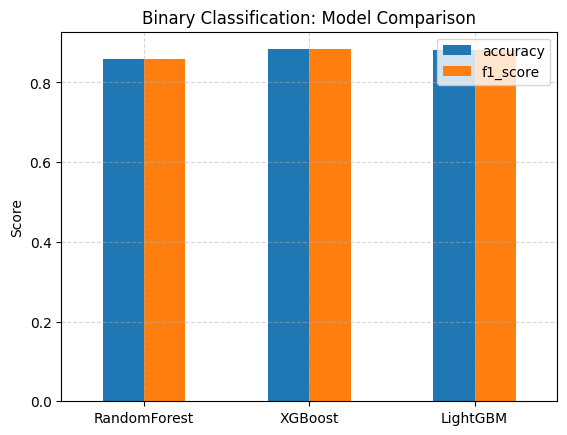

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tree-based models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# --------------------------
# Load data
# --------------------------
df = pd.read_csv("data_hep - data_hep.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Binary mapping
def map_binary(t):
    if t in (0,1):
        return "BB"
    else:
        return "continuum"

df["binary_label"] = df["type"].map(map_binary)
print("Event counts:\n", df["binary_label"].value_counts())

# Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != "type"]

# Drop constants and low variance
const_cols = [c for c in features if df[c].nunique() <= 1]
df = df.drop(columns=const_cols)
features = [f for f in features if f not in const_cols]

variances = df[features].var()
low_var = variances[variances < 1e-8].index.tolist()
df = df.drop(columns=low_var)
features = [f for f in features if f not in low_var]

# --------------------------
# Train/test split
# --------------------------
X = df[features].fillna(0).values
y = df["binary_label"].values

le = LabelEncoder()
y_enc = le.fit_transform(y)  # 0 = BB, 1 = continuum

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.25, stratify=y_enc, random_state=42
)

# Scale features
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# --------------------------
# Models dictionary
# --------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

# --------------------------
# Train, predict, evaluate
# --------------------------
results = {}

for name, model in models.items():
    model.fit(Xtr_s, ytr)
    ypred = model.predict(Xte_s)

    print(f"\n=== {name} ===")
    print(classification_report(yte, ypred, target_names=le.classes_, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(yte, ypred))

    results[name] = {
        "accuracy": (ypred == yte).mean(),
        "f1_score": classification_report(yte, ypred, output_dict=True)["macro avg"]["f1-score"]
    }

# --------------------------
# Compare accuracies and F1
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel comparison:\n", results_df)

# Plot comparison
plt.figure(figsize=(6,4))
results_df[["accuracy","f1_score"]].plot(kind='bar', rot=0)
plt.title("Binary Classification: Model Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
